<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and Random Forests - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

# declaring X and y variables
X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

#print(boston['DESCR'])

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


In [4]:
# addressing NULL values -- no NULL values returned
empty_val = X.loc[:, X.isnull().sum() > 0]
empty_val.columns.tolist()

[]

In [5]:
# checking datatypes
# all numerical variables so no necessary encoding -- only need to scale
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [6]:
X.describe()

# large deviation in TAX column, etc. so, again, need to scale data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [7]:
X -= np.mean(X)
X /= np.std(X)

In [8]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()

In [9]:
# create training & testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [ ]:
#sc.fit_transform(X_train);

In [ ]:
# scale testing set using training set stats
#sc.transform(X_test);

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from sklearn.linear_model import Ridge

ridge = Ridge()

In [11]:
# check correlation values between MEDV and columns
# temporary merge on dataframes

X_train['MEDV'] = y_train
X_train.corr()['MEDV'].sort_values(ascending=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


MEDV       1.000000
RM         0.701820
ZN         0.336494
B          0.324046
DIS        0.247688
CHAS       0.203227
AGE       -0.370941
CRIM      -0.406673
RAD       -0.412563
NOX       -0.425840
INDUS     -0.493582
TAX       -0.498500
PTRATIO   -0.512577
LSTAT     -0.731312
Name: MEDV, dtype: float64

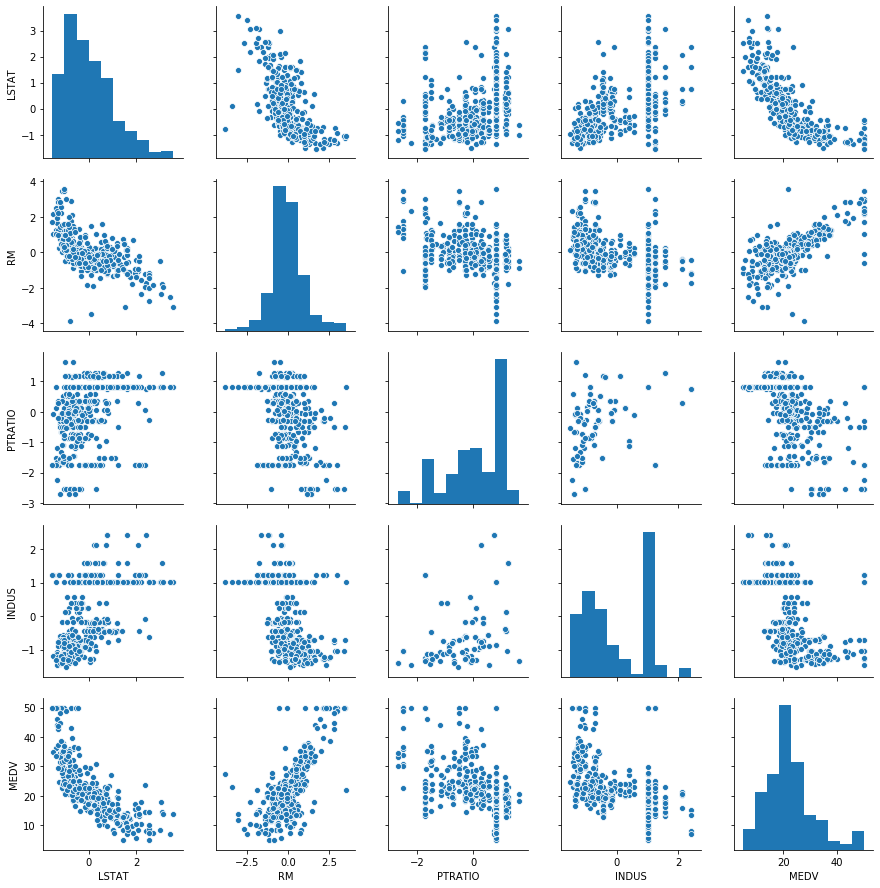

In [12]:
# Noticed there were negative correlations -- accompanying visuals
# only looking at scatterplots of MEDV and predictors
X_train = X_train[['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'MEDV']]
sns.pairplot(X_train);

In [13]:
# Declare predictors = LSTAT, RM, PTRATIO, INDUS
# LSTAT is parabolic
# RM seems to have a fairly strong linear correlation
# PTRATIO seems shaky
# INDUS seems shakily parabolic
X_train = X_train.drop('MEDV', axis=1)

In [17]:
from sklearn.model_selection import cross_val_score

ridge.fit(X_train, y_train)
np.mean(cross_val_score(estimator=ridge, X=X_train, y=y_train, cv=10))

0.649945309402244

In [18]:
# perform basis expansion on LSTAT to improve og model score
X_train['LSTAT2'] = X_train['LSTAT'] ** 2
ridge.fit(X_train, y_train)
np.mean(cross_val_score(estimator=ridge, X=X_train, y=y_train, cv=10))

0.6910402809720916

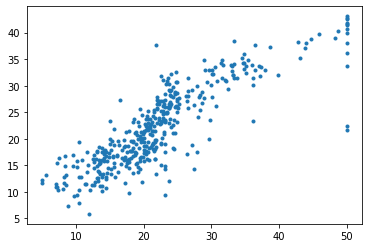

In [19]:
prediction = ridge.predict(X_train)

# plot predictions -- fairly positive correlation!

plt.plot(y_train, prediction, '.');

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [20]:
test_size_samples = np.arange(0.1, 0.3, 0.05)
test_size_scores = []

for size in test_size_samples:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=4)
    ridge.fit(X_train, y_train)
    score = np.mean(cross_val_score(estimator=ridge, X=X_train, y=y_train, cv=10))
    test_size_scores.append((score, size))

In [21]:
max(test_size_scores)

# 10% test set is the most optimal

(0.7132791132226375, 0.1)

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [22]:
fold_samples = np.arange(5,11)
fold_scores = []
fold_list = []

for fold in fold_samples:
    score = np.mean(cross_val_score(estimator=ridge, X=X_train, y=y_train, cv=fold))
    fold_scores.append((score,fold))
    fold_list.append(score)

In [23]:
max(fold_scores)

(0.7215226338473467, 6)

Text(0.5, 1.0, 'K-FOLD Validation Scores')

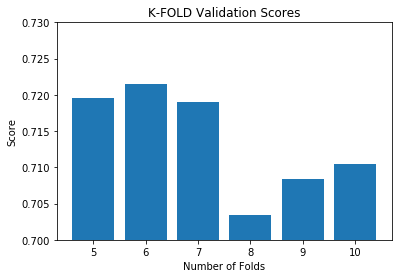

In [27]:
# 6-fold CV seems most optimal
# typically as you add more folds, the scores get lower
# trade-off: more folds represents a wider spread of worst & best case scenarios

plt.bar(fold_samples, fold_list)
plt.ylim([0.70, 0.73])
plt.ylabel('Score')
plt.xlabel('Number of Folds')
plt.title('K-FOLD Validation Scores')

## Using Random Forests With the Boston Dataset

#### Create X and y variables for Your Data

In [28]:
# declare variables
X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

#### Divide it into a training and test set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

In [30]:
# standardize data
X_train -= np.mean(X_train)
X_train /= np.std(X_train)

In [31]:
X_test -= np.mean(X_train)
X_test /= np.std(X_train)

#### Fit a Random Forest on the data

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [33]:
rf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### What are its most important features?

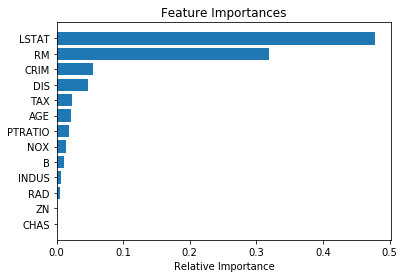

In [34]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.xlabel('Relative Importance')
plt.yticks(range(len(indices)), [features[i] for i in indices]);

# RM and LSTAT are the most important features
# they hold the most weight of all variables on target variable

#### How well does your model perform on your test set?

In [42]:
np.mean(cross_val_score(estimator=rf, X=X_train, y=y_train, cv=fold))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

0.8371900501194528

In [59]:
pred = rf.predict(X_test)

# Calculating Mean Absolute Error
pred.shape = (51,1)
errors = abs(pred - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# RF Model 71.17% accuracy

Accuracy: MEDV    71.17
dtype: float64 %.


#### Challenge:  Try and find at least two improvements to your model to improve test scores.

You can try the following:
 - increasing the number of trees
 - using a different number of maximum features to sample
 - using a different number of minimum samples per leaf

In [60]:
# min_samples_leaf = 1: min number of samples within a leaf
# n_estimators = 10: dictates number of trees to grow in forest
# max_features = auto: what % of columns randomly sampled at each node
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [61]:
# optimizing min samples per leaf parameter
leaf_samples = [1, 5, 10, 25]
rf_scores = []

for sample in leaf_samples:
    rf.set_params(min_samples_leaf=sample)
    scores = cross_val_score(estimator=rf, X=X_train, y=y_train.values.ravel(), cv=10)
    rf_scores.append((np.mean(scores), sample))

In [62]:
max(rf_scores)

(0.8490128104048281, 1)

In [63]:
# best score is with min 1 samples per leaf so adjusting parameter
rf = rf.set_params(min_samples_leaf = 1)

In [69]:
# optimizing number of trees parameter
tree_samples = np.arange(5, 30, 5)
tree_scores = []

for tree in tree_samples:
    rf.set_params(n_estimators=tree)
    scores = cross_val_score(estimator=rf, X=X_train, y=y_train.values.ravel(), cv=6)
    tree_scores.append((np.mean(scores), tree))

In [70]:
max(tree_scores)

(0.8508814947454648, 25)

In [71]:
# score improved with 25 trees in forest
rf = rf.set_params(n_estimators=25)

In [72]:
# optimizing % sampled per cut point
percent_samples = np.arange(0.1, 1.1, 0.1)
percent_scores = []

for percent in percent_samples:
    rf.set_params(max_features=percent)
    scores = cross_val_score(estimator=rf, X=X_train, y=y_train.values.ravel(), cv=6)
    percent_scores.append((np.mean(scores), percent))

In [73]:
max(percent_scores)
# score went down

(0.8712998224455353, 0.6)

In [74]:
# highest score when 60% cols sampled
rf = rf.set_params(max_features=0.6)

In [76]:
# lets see if the score improved on test set!
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

# Calculating Mean Absolute Error
pred.shape = (51,1)
errors = abs(pred - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# RF Model 72.01% accuracy -- improved by 1%!

Accuracy: MEDV    72.01
dtype: float64 %.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [77]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [78]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1221.
Date:                Thu, 12 Mar 2020   Prob (F-statistic):                   1.38e-321
Time:                        18:25:51   Log-Likelihood:                         -1567.5
No. Observations:                 506   AIC:                                      3151.
Df Residuals:                     498   BIC:                                      3185.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9729      0.224     22.195      0.000       4.533       5.413
LSTAT         -0.5606      0.048    -11.795      0.000      -0.654      -0.467
RAD            0.2128      0.070      3.050      0.002       0.076       0.350
TAX           -0.0174      0.004     -4.272      0.000      -0.025      -0.009
NOX            4.3448      3.384      1.284      0.200      -2.304      10.994
INDUS          0.0924      0.067      1.383      0.167      -0.039       0.224
CRIM          -0.0891      0.037     -2.423      0.016      -0.161      -0.017
ZN             0.0288      0.013      2.220      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.139   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.155
Skew:                           1.666   Prob(JB):                    1.99e-181
Kurtosis:                       8.326   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

In [ ]:
# Check out Pearson scores
